In [31]:
import psycopg2
from dotenv import load_dotenv
import os
import pandas as pd
import warnings
import datetime
import seaborn

In [7]:
repo = os.getenv("REPO","apache/airflow")
dbname = os.getenv("PG_DB", "app")
user = os.getenv("PG_USER", "postgres")
password = os.getenv("PG_PW", "example")
dbhost = os.environ.get("PG_HOST","localhost")

In [15]:
def query_to_dataframe(sqlsquery): 
    with psycopg2.connect(dbname=dbname, user=user, password=password, host=dbhost) as conn:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            data = pd.read_sql(sql,conn)
    return data

## Top 5 committers in the last 6 months

In [20]:
top5query = "select distinct author, count(id) from app.ft_commits where datetime > (CURRENT_DATE - interval '6 month') group by author order by count desc limit 5"

query_to_dataframe(top5query)

,author,streak_start,streak_end,streak_length
0,Jarek Potiuk,2023-07-26,2023-08-16,22
1,Jarek Potiuk,2023-08-21,2023-09-02,13
2,Andrey Anshin,2023-08-20,2023-09-01,13
3,Jarek Potiuk,2023-06-22,2023-07-02,11
4,Jarek Potiuk,2023-05-15,2023-05-24,10


## Top 5 longest commit streaks

In [21]:
streakquery = """select 
author, 
min(commitdate) streak_start, 
max(commitdate) streak_end, 
count(commitdate) streak_length 
from (
    select 
    author, 
    commitdate, 
    commitdate::date - rownum::int as category
    from (
        select distinct 
            author, 
            date(datetime) as commitdate, 
            dense_rank() over (partition by author order by date(datetime)) as rownum
            from app.ft_commits
            where datetime > (current_date) - interval '6 month'
            order by author, commitdate
        ) a
    )  b
group by b.author, b.category 
order by streak_length desc 
limit 5"""

query_to_dataframe(streakquery)

,author,streak_start,streak_end,streak_length
0,Jarek Potiuk,2023-07-26,2023-08-16,22
1,Jarek Potiuk,2023-08-21,2023-09-02,13
2,Andrey Anshin,2023-08-20,2023-09-01,13
3,Jarek Potiuk,2023-06-22,2023-07-02,11
4,Jarek Potiuk,2023-05-15,2023-05-24,10


## Heatmap of commits by day of week and time of day

<Axes: xlabel='Time of Day', ylabel='Day of Week'>

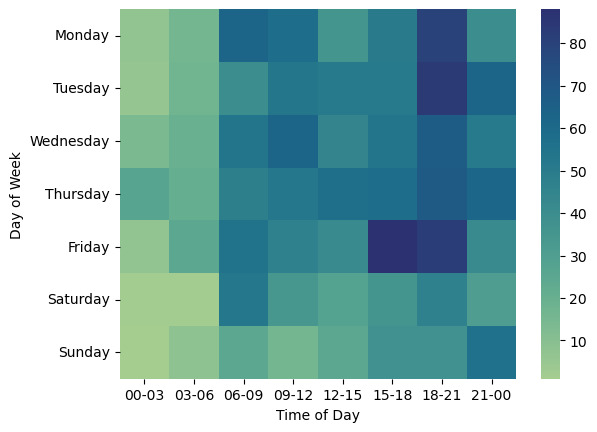

In [61]:
sql = "select datetime from app.ft_commits where datetime > (current_date - interval '6 month')"
data = query_to_dataframe(sql)
data["Day of Week"] = data["datetime"].dt.day_name()

data['Day of Week'] = data['Day of Week'].astype('category')

data["Time of Day"] = data["datetime"].dt.hour.map(lambda x: "00-03" if x < 3 
                                                   else "03-06" if x < 6 
                                                   else "06-09" if x < 9
                                                  else "09-12" if x < 12
                                                  else "12-15" if x < 15
                                                  else "15-18" if x < 18
                                                  else "18-21" if x < 21
                                                  else "21-00")
pivoted = data.groupby(["Day of Week","Time of Day"]).count().reset_index().pivot(index="Day of Week", columns="Time of Day", values="datetime")

# Currently the days of week are being sorted alphabetically, reorder them
dayorder = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
pivoted.index = pivoted.index.reorder_categories(dayorder, ordered=True)
pivoted.sort_index(axis ="index",inplace=True)

seaborn.heatmap(pivoted, cmap="crest")